In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.interpolate import interp1d
import seaborn as sns
import os
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pickle
import sys

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

sys.path.insert(0, '../Run')
from ClassFunctions import precip_time_series, rainfall_analysis
from MethodsPlottingFunctions import *

In [2]:
def get_non_overlapping_y(desired_y, used_ys, spacing=1.0, line_y=None):
    """
    Finds a non-overlapping y-coordinate for label placement.

    Parameters:
    - desired_y: proposed y-coordinate (e.g. slightly offset from data point)
    - used_ys: list of y-values already used (mutated in-place)
    - spacing: minimum vertical distance between labels
    - line_y: (optional) reference y-value for nudging direction
    
    Returns:
    - adjusted_y: a y-value that does not overlap with any in used_ys
    """
    adjusted_y = desired_y
    attempt = 0
    max_attempts = 100

    while any(abs(adjusted_y - y) < spacing for y in used_ys) and attempt < max_attempts:
        # Alternate nudging up/down around the line_y if provided
        if line_y is not None:
            direction = (-1) ** attempt  # alternate +1, -1
            adjusted_y = desired_y + direction * spacing * ((attempt + 1) // 2)
        else:
            adjusted_y += spacing
        attempt += 1

    used_ys.append(adjusted_y)
    return adjusted_y


## Create object containing rainfall events for one gauge

In [3]:
all_events =[]
for file in os.listdir("../../DanishRainData_Outputs/5mins/"):
    df = pd.read_csv(f"../../DanishRainData_Outputs/5mins/{file}")
    df['event_num']=range(0, len(df))
    all_events.append(df)
all_events_df = pd.concat(all_events)   

In [4]:
# import matplotlib.pyplot as plt
# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "serif",
#     "font.serif": ["Computer Modern Roman"],})

In [45]:
def plot_classification_metrics(rainfall, df, suffix, save_path):
    boundary_color = 'navy'
    shading_color = 'grey'
    if suffix in ['_norm', '_dblnorm']:
        cumulative_rainfall = rainfall.iloc[:, 0].to_numpy()
        incremental_rainfall = np.diff(cumulative_rainfall, prepend=0)
        times = np.linspace(0, 1, len(rainfall))
    else:
        times = rainfall.index
        incremental_rainfall = rainfall.iloc[:, 0].to_numpy()
        cumulative_rainfall = np.cumsum(incremental_rainfall)

    total = cumulative_rainfall[-1]
    if total == 0:
        print("Total rainfall is zero; nothing to plot.")
        return

    fig, axs = plt.subplots(4, 1, figsize=(12, 10), sharex=True, gridspec_kw={'height_ratios': [1,2,2, 2]})
    
    ##############################################
    # 5th with peak
    ##############################################
    bar_ax = axs[2]
    bar_ax.plot(times, cumulative_rainfall, label='Cumulative Rainfall', color='black', linewidth=3)
    event_duration = times[-1] - times[0]
    steps = len(cumulative_rainfall)

    fifth_w_peak = df[f'5th_w_peak{suffix}']
    fifth_size = steps // 5
    fifth_edges = [i * fifth_size for i in range(5)] + [steps - 1]
    fifth_w_peak_i = int(fifth_w_peak) + 1
    start_idx, end_idx = fifth_edges[fifth_w_peak_i - 1], fifth_edges[fifth_w_peak_i]

    y_values = cumulative_rainfall
    bar_ax.fill_between(times[start_idx:end_idx + 1], 0, y_values[start_idx:end_idx + 1], color=shading_color, alpha=0.8)
    for edge in fifth_edges[fifth_w_peak_i - 1:fifth_w_peak_i + 1]:
        if edge < steps:
            bar_ax.plot([times[edge], times[edge]], [0, y_values[edge]], color='grey', linestyle='solid', linewidth=2)
    
    for edge in fifth_edges[1:-1]:  # skip 0 and last
        bar_ax.axvline(times[edge], color=boundary_color, linestyle='dotted', linewidth=2, label='_nolegend_')
    for i in range(5):
        center_idx = (fifth_edges[i] + fifth_edges[i + 1]) // 2
        bar_ax.text(times[center_idx], total * 0.9, f'Fifth {i+1}', ha='center', fontsize=15, color=boundary_color)

    summary_text = (f"5th with most:\n   {fifth_w_peak[0]+1}")
    bar_ax.text(0.82,0.26,summary_text,transform=bar_ax.transAxes, fontsize=15,color='black', va='top',
        ha='left', bbox=dict(facecolor='white', edgecolor='grey', alpha=0.9), clip_on=False)
#     bar_ax.legend(loc='upper left', bbox_to_anchor=(1.01, 1.3))        
        
    ##############################################
    # 3rd with peak
    ##############################################
    # Find peak intensity index and time
    peak_idx = int(np.argmax(incremental_rainfall))
    peak_time = times[peak_idx]
    
    bar_ax = axs[1]
    bar_ax.plot(times, cumulative_rainfall, label='Cumulative Rainfall', color='black', linewidth=3)

    # Determine which third contains the peak
    steps = len(cumulative_rainfall)
    third_size = steps // 3
    third_edges = [i * third_size for i in range(3)] + [steps - 1]

    # Compute which third the peak index is in
    for i in range(3):
        if third_edges[i] <= peak_idx <= third_edges[i + 1]:
            third_w_peak_i = i + 1
            break

    start_idx, end_idx = third_edges[third_w_peak_i - 1], third_edges[third_w_peak_i]

    # Shade the third that contains the peak
    bar_ax.fill_between(times[start_idx:end_idx + 1], 0, cumulative_rainfall[start_idx:end_idx + 1],
                        color=shading_color, alpha=0.8)

    # Draw vertical lines for that third's boundaries
    for edge in third_edges[third_w_peak_i - 1:third_w_peak_i + 1]:
        if edge < steps:
            bar_ax.plot([times[edge], times[edge]], [0, cumulative_rainfall[edge]],
                        color='grey', linestyle='solid', linewidth=2)

    # Draw dotted lines separating all thirds
    for edge in third_edges[1:-1]:
        bar_ax.axvline(times[edge], color=boundary_color, linestyle='dotted', linewidth=2, label='_nolegend_')

    # Add labels
    ymax = bar_ax.get_ylim()[1]
    for i in range(3):
        center_idx = (third_edges[i] + third_edges[i + 1]) // 2
        bar_ax.text(times[center_idx], ymax * 0.9, f'Third {i+1}', ha='center', fontsize=15, color=boundary_color)

    # Summary box
    summary_text = f"3rd with peak:\n   {third_w_peak_i}"
    bar_ax.text(0.82, 0.26, summary_text, transform=bar_ax.transAxes, fontsize=15, color='black', va='top',
                ha='left', bbox=dict(facecolor='white', edgecolor='grey', alpha=0.9), clip_on=False)

    # >>> Draw vertical line on axs[1] aligned with peak intensity <<< #
    bar_ax.axvline(peak_time, color='red', linestyle='dashed', linewidth=2)
    offset = (times[-1] - times[0]) * 0.02  # 2% of total time span
    bar_ax.text(peak_time + offset, axs[1].get_ylim()[1] * 0.7, 'Peak intensity', 
                color='red', ha='left', va='top', fontsize=20)

    
    ##############################################
    # 3rd with D50
    ##############################################
    bar_ax=axs[3]
    bar_ax.plot(times, cumulative_rainfall, label='Cumulative Rainfall', color='black', linewidth=3)
    bar_ax.set_ylim(bottom=0)
    
    # Segment the rainfall event into 0–40%, 40–60%, and 60–100%
    steps = len(cumulative_rainfall)
    edge_40 = int(steps * 0.4)
    edge_60 = int(steps * 0.6)
    segment_edges = [0, edge_40, edge_60, steps - 1]

    # Plot vertical lines on axs[2]
    for edge in segment_edges[1:-1]:  # skip 0 and last
        bar_ax.axvline(times[edge], color=boundary_color, linestyle='dotted', linewidth=2, label='_nolegend_')

    # Add text labels
    ymax = bar_ax.get_ylim()[1]
    segment_labels = ['0–40%', '40–60%', '60–100%']
    for i in range(3):
        center_idx = (segment_edges[i] + segment_edges[i + 1]) // 2
        bar_ax.text(times[center_idx], ymax * 0.9, segment_labels[i], ha='center', fontsize=15, color=boundary_color)

    # Shade selected segment on axs[2]
    selected_segment = df['3rd_ARR'][0] -1
    start_idx, end_idx = segment_edges[selected_segment], segment_edges[selected_segment + 1]
    bar_ax.fill_between(times[start_idx:end_idx + 1], 0, cumulative_rainfall[start_idx:end_idx + 1],
                        color=shading_color, alpha=0.8)

    # Draw solid vertical lines around selected segment
    for edge in segment_edges[selected_segment:selected_segment + 2]:
        if edge < steps:
            bar_ax.plot([times[edge], times[edge]], [0, cumulative_rainfall[edge]],
                        color='grey', linestyle='solid', linewidth=2)
        
        
    spacing = total * 0.1
    used_ys = []
    for dx_value, color in zip([50,], [boundary_color]):
        dx_frac = df[f'T{dx_value}{suffix}'][0] / 100  # Fraction (e.g., 0.5 for 50%)
        dx_y = dx_value/100
        dx_y = dx_y * total  # Actual rainfall value for this Dx        
        cumulative = cumulative_rainfall  # Not normalized — use raw cumulative rainfall

        # Interpolate to find x (time) where cumulative crosses dx_y
        for i in range(1, len(cumulative)):
            if cumulative[i-1] <= dx_y <= cumulative[i]:
                x0, x1 = times[i-1], times[i]
                y0, y1 = cumulative[i-1], cumulative[i]
                dx_time = x0 + (dx_y - y0) * (x1 - x0) / (y1 - y0)
                break
        else:
            dx_time = times[-1]  # Fallback

        # Horizontal dashed line from y-axis to intersection
        bar_ax.hlines(dx_y, times[0], dx_time, color=color, linestyle='dashed', lw=1.5)

        # Vertical dashed arrow from intersection to x-axis
        bar_ax.annotate("", xy=(dx_time, 0), xytext=(dx_time, dx_y),
                        arrowprops=dict(arrowstyle="->", linestyle='dashed', lw=1.5, color=color))

        # Avoid overlapping annotation text
        annot_y = get_non_overlapping_y(dx_y + total * -0.3, used_ys, spacing, line_y=dx_y)
        used_ys.append(annot_y)

        # Add label with arrow
        bar_ax.annotate(f"D{dx_value} = {dx_frac*100:.1f}%", xy=(dx_time, dx_y),
                        xytext=(dx_time, annot_y),
                        arrowprops=dict(arrowstyle="->", lw=1.2, color=color),
                        fontsize=19, color=color)
        
    summary_text = (f"3rd with D50: \n 3")
    bar_ax.text(0.82,0.27, summary_text,transform=bar_ax.transAxes, fontsize=15,color='black', va='top',
        ha='left', bbox=dict(facecolor='white', edgecolor='grey', alpha=0.9), clip_on=False)
                    
    ###############################
    #### BOTTOM PLOT
    ###############################
    bar_ax=axs[0]
    if suffix in ['_norm', '_dblnorm']:
        bar_width = 1 / steps
        bar_x = np.linspace(bar_width / 2, 1 - bar_width / 2, steps)
        bar_ax.bar(bar_x, incremental_rainfall, width=bar_width, align='center', color='steelblue', alpha=0.7, edgecolor='black')
        bar_ax.set_xlim(0, 1)
        bar_ax.set_xticks([0, 0.25, 0.5, 0.75, 1])
        bar_ax.set_xticklabels(['0%', '25%', '50%', '75%', '100%'])
    else:
        bar_x = times
        if isinstance(times[0], pd.Timestamp):
            time_deltas = np.diff(times) / np.timedelta64(1, 's')
            avg_dt = np.mean(time_deltas)
            bar_width = pd.to_timedelta(avg_dt, unit='s')
        else:
            bar_width = (times[1] - times[0])

        bar_ax.bar(bar_x, incremental_rainfall, width=bar_width,
                   align='center', color='steelblue', alpha=0.7, edgecolor='black')
        bar_ax.set_xlim(times[0], times[-1])

    axs[0].set_ylabel("Rainfall\n(mm)" if suffix == '' else "Rainfall\n(Fraction)", fontsize=15)
    axs[3].set_xlabel("Time" if suffix == '' else "Dimensionless Time", fontsize=15)
    axs[0].set_ylim(bottom=0)
    
    axs[0].set_title('(a) Raw rainfall', fontsize=23)
    axs[2].set_title('(b) 5th with most', fontsize=23)
    axs[1].set_title('(c) 3rd with peak', fontsize=23)
    axs[3].set_title('(d) 3rd ($D_{50}$)', fontsize=25)
        
    for bar_ax in [axs[1], axs[2], axs[3]]:
        bar_ax.set_ylabel("Cumulative rainfall\n(mm)", fontsize=15)
        
    fig.subplots_adjust(hspace=0.3)  
    
    plt.tight_layout() 
    plt.savefig(save_path, dpi=300, facecolor='white')

In [6]:
# event_id = 35    # 34 is interesting
# gauge_id = 598120

# file = open(f'/nfs/a319/gy17m2a/Metrics/DanishRainDataPickles/{gauge_id}_precip_minute.csv.pkl','rb')
# object_file = pickle.load(file)

# this_gauge_df = all_events_df[all_events_df['gauge_num']==gauge_id]
# this_event_df = this_gauge_df[this_gauge_df['event_num']==event_id]
# this_event_df.reset_index(inplace=True, drop=True)

# event = object_file.raw_events[event_id]
# plot_classification_metrics(event, this_event_df, '', 'Figures/thisfig.jpg')

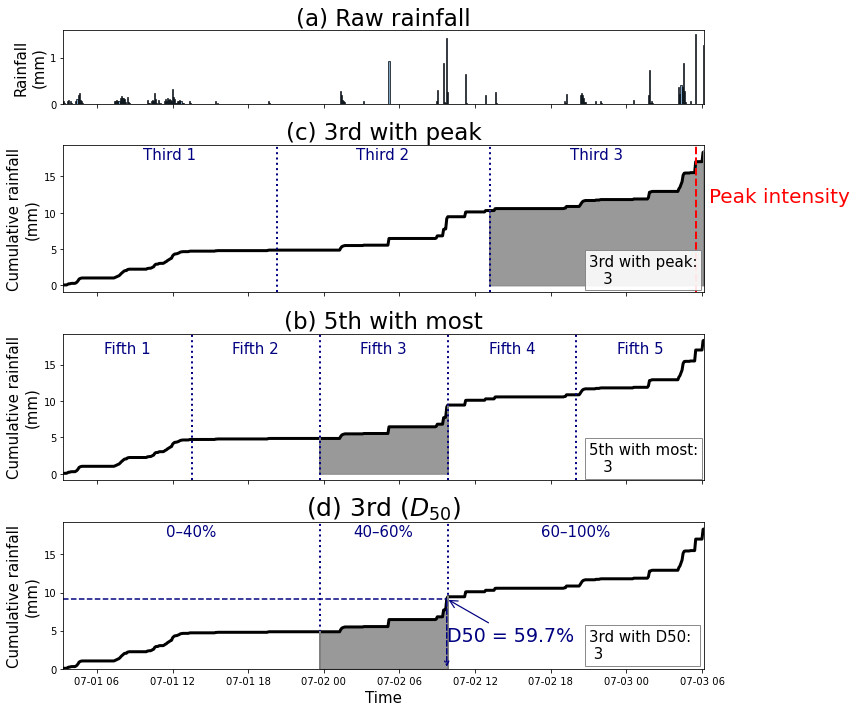

In [46]:
event_id = 18
gauge_id = 598120

file = open(f'/nfs/a319/gy17m2a/Metrics/DanishRainDataPickles/{gauge_id}_precip_minute.csv.pkl','rb')
object_file = pickle.load(file)

this_gauge_df = all_events_df[all_events_df['gauge_num']==gauge_id]
this_event_df = this_gauge_df[this_gauge_df['event_num']==event_id]
this_event_df.reset_index(inplace=True, drop=True)

event = object_file.raw_events[event_id]
event["precipitation (mm/min)"][-9] = 1.51
plot_classification_metrics(event, this_event_df, '', '../Figures/metrics_1.png')

In [47]:
def plot_summary_stats(rainfall, df, suffix, save_path):
    def get_non_overlapping_y(candidate_y, used_ys, spacing, line_y):
        for y in used_ys:
            if abs(candidate_y - y) < spacing:
                return get_non_overlapping_y(candidate_y + spacing, used_ys, spacing, line_y)
        return candidate_y

    if suffix in ['_norm', '_dblnorm']:
        cumulative_rainfall = rainfall.iloc[:, 0].to_numpy()
        incremental_rainfall = np.diff(cumulative_rainfall, prepend=0)
        times = np.linspace(0, 1, len(rainfall))
    else:
        times = rainfall.index
        incremental_rainfall = rainfall.iloc[:, 0].to_numpy()
        cumulative_rainfall = np.cumsum(incremental_rainfall)

    total = cumulative_rainfall[-1]
    if total == 0:
        print("Total rainfall is zero; nothing to plot.")
        return

    fig, axs = plt.subplots(2, 1, figsize=(18, 10), sharex=True, gridspec_kw={'height_ratios': [1, 4]})
    
    
    #############
    # top plot
    #############
    bar_ax = axs[1]
    bar_ax.plot(times, cumulative_rainfall, label='Cumulative Rainfall', color='black', linewidth=3)

    idxs = ['m4', 'm5']
    time_fractions = [0.30,  0.50]
    spacing = total * 0.07
    event_duration = times[-1] - times[0]
    steps = len(cumulative_rainfall)

    used_text_xs = []
    for num, fraction in enumerate(time_fractions):
        time_at_fraction = fraction * event_duration + times[0]
        idx = (np.abs(times - time_at_fraction)).argmin()
        time_at_fraction = times[idx]
        rainfall_at_time = cumulative_rainfall[idx]

        bar_ax.fill_between(times, 0, cumulative_rainfall, where=(times <= time_at_fraction), 
                            color='lightgrey', alpha=0.5,
                            label=f'{int(fraction*100)}\% of Event')
#                             label=f'{int(fraction*100)}% of Event')
        bar_ax.plot(time_at_fraction, rainfall_at_time, color='black', marker = 'o')

        fraction_rainfall = rainfall_at_time / total
        text_position_y = rainfall_at_time * 0.3
        text_x = time_at_fraction - 0.1 if not isinstance(time_at_fraction, (pd.Timestamp, pd.DatetimeIndex, np.datetime64)) else pd.to_datetime(time_at_fraction) - pd.Timedelta(minutes=30)

        # Check for x overlaps
        while text_x in used_text_xs:
            text_x += 0.05 if not isinstance(text_x, pd.Timestamp) else pd.Timedelta(minutes=4)
        used_text_xs.append(text_x)
        bar_ax.text(text_x, text_position_y, 
                   f'{idxs[num]}',
#                    f'{idxs[num]}: {fraction_rainfall*100:.1f}% rainfall \n in first {fraction*100} \% of event)',
                    color='black', ha='center', fontsize=20)

    used_ys = []
    for dx_value, color in zip([25, 50, 75], ['darkgreen', 'darkgreen', 'darkgreen']):
        dx_frac = df[f'T{dx_value}{suffix}'][0] / 100  # Fraction (e.g., 0.5 for 50%)
        dx_y = dx_value/100
        dx_y = dx_y * total  # Actual rainfall value for this Dx        
        cumulative = cumulative_rainfall  # Not normalized — use raw cumulative rainfall

        # Interpolate to find x (time) where cumulative crosses dx_y
        for i in range(1, len(cumulative)):
            if cumulative[i-1] <= dx_y <= cumulative[i]:
                x0, x1 = times[i-1], times[i]
                y0, y1 = cumulative[i-1], cumulative[i]
                dx_time = x0 + (dx_y - y0) * (x1 - x0) / (y1 - y0)
                break
        else:
            dx_time = times[-2]  # Fallback

        # Horizontal dashed line from y-axis to intersection
        bar_ax.hlines(dx_y, times[0], dx_time, color=color, linestyle='dashed')

        # Vertical dashed arrow from intersection to x-axis
        bar_ax.annotate("", xy=(dx_time, 0), xytext=(dx_time, dx_y),
                        arrowprops=dict(arrowstyle="->", linestyle='dashed', lw=1.2, color=color))

        # Avoid overlapping annotation text
        annot_y = get_non_overlapping_y(dx_y + total * 0.05, used_ys, spacing, line_y=dx_y)
        used_ys.append(annot_y)

        # Add label with arrow
        dx_time_label = pd.to_datetime(dx_time) - pd.Timedelta(minutes=35)
        bar_ax.annotate(f"T{dx_value} = {dx_frac*100:.1f}\%", xy=(dx_time, dx_y),
                        xytext=(dx_time_label, annot_y),
                        arrowprops=dict(arrowstyle="->", lw=1.2, color=color),
                        fontsize=20, color=color)


    peak_idx = np.argmax(incremental_rainfall)
    bar_ax.annotate('', xy=(times[peak_idx], total * 0.98), xytext=(times[0], total * 0.98),
                    arrowprops=dict(arrowstyle='<->', lw=2, color='darkgreen'))
    time_to_peak = times[peak_idx] - times[0]
#     time_to_peak_str = f"{(time_to_peak*100):.1f}%" if suffix != '' else f"{time_to_peak}"
    hours, remainder = divmod(time_to_peak.total_seconds(), 3600)
    minutes = remainder // 60
    formatted = f"{int(hours)}h {int(minutes)}m"

    bar_ax.text(times[peak_idx // 2], total * 0.99, f"Time to Peak = {formatted}", color='darkgreen', ha='center', 
                fontsize=20)
    
    bar_ax.set_xlabel("Time" if suffix == '' else "Dimensionless Time", fontsize=25)
    bar_ax.set_ylabel("Cumulative rainfall (mm)" if suffix == '' else "Cumulative Fraction", fontsize=20)
#     bar_ax.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize=25)

    # === Centre of Gravity (Centre of Mass) ===
    rcg = df[f'centre_gravity{suffix}']
    if suffix in ['_dblnorm', '_norm']:
        x_pos = rcg[0]
    else:
        x_idx = int(round(rcg * (len(times) - 1)))
        x_pos = times[x_idx]
        x_pos = pd.to_datetime(x_pos) - pd.Timedelta(minutes=30)

    idx = (np.abs(times - x_pos)).argmin()
    y_value = cumulative_rainfall[idx]

    # Calculate vertical distance from D50 (or any close metric)
    d50_frac = df[f'T50{suffix}'][0] / 100
    d50_idx = int(round(d50_frac * (steps - 1)))
    d50_y = cumulative_rainfall[d50_idx]

    # Check if overlap is likely (adjust threshold as needed)
    min_y_gap = total * 0.05  # Minimum vertical space
    if abs(y_value - d50_y) < min_y_gap:
        y_annot = y_value + min_y_gap  # Push upwards
    else:
        y_annot = y_value + total * 0.1

    # Handle x-position offset if needed
    if isinstance(x_pos, (pd.Timestamp, pd.DatetimeIndex, np.datetime64)):
        x_text = pd.to_datetime(x_pos) + pd.Timedelta(minutes=5)
    else:
        x_text = x_pos + 0.05

    bar_ax.plot([x_pos, x_pos], [0, y_value], color='darkgreen', linestyle='dashed')
    bar_ax.plot(x_pos, y_value, 'o', color='darkgreen', markersize=8)
    
    bar_ax.annotate(f"Centre of Mass {rcg[0]*100:.1f}\%",
                    xy=(x_pos, y_value),
                    xytext=(x_text, y_annot),
                    arrowprops=dict(arrowstyle="->", lw=1.5, color='darkgreen'),
                    fontsize=20, color='darkgreen', ha='center')

    rain_before_peak = np.sum(incremental_rainfall[:peak_idx + 1])
    rain_after_peak = np.sum(incremental_rainfall[peak_idx + 1:])
    m1 = rain_before_peak / rain_after_peak if rain_after_peak != 0 else np.inf
    m2 = np.max(incremental_rainfall) / np.sum(incremental_rainfall)
    summary_text = (f"Rainfall before peak:\n  {rain_before_peak:.2f} mm\n\n"
                    f"Rainfall after peak:\n  {rain_after_peak:.2f} mm\n\n"
                    f"m1 (before/after):\n  {m1:.2f} \n\n"
                    f"m2 (rain in peak/whole event):\n  {m2:.2f}\n\n"
                    f"m3 (rainfall in first 30\% of event): 24.3\% \n\n"
                    f"m5 (rainfall in first 50\% of event): 27.0\% \n\n")

    bar_ax.text(1.02, 0.75, summary_text, transform=bar_ax.transAxes,
                fontsize=20, color='black', va='top', ha='left',
                bbox=dict(facecolor='white', edgecolor='grey', alpha=0.9))

    bar_ax.legend(loc='upper left', bbox_to_anchor=(1.01, 1.0), fontsize=20)
    bar_ax.set_ylim(bottom=0)
    
    ######################
    # Bottom plot
    ######################
    bar_ax = axs[0]
    
    if suffix in ['_norm', '_dblnorm']:
        bar_width = 1 / steps
        bar_x = np.linspace(bar_width / 2, 1 - bar_width / 2, steps)
        bar_ax.bar(bar_x, incremental_rainfall, width=bar_width, align='center', color='steelblue', alpha=0.7, edgecolor='black')
        bar_ax.set_xlim(0, 1)
        bar_ax.set_xticks([0, 0.25, 0.5, 0.75, 1])
        bar_ax.set_xticklabels(['0%', '25%', '50%', '75%', '100%'])
    else:
        bar_x = times
        if isinstance(times[0], pd.Timestamp):
            time_deltas = np.diff(times) / np.timedelta64(1, 's')
            avg_dt = np.mean(time_deltas)
            bar_width = pd.to_timedelta(avg_dt, unit='s')
        else:
            bar_width = (times[1] - times[0])

        bar_ax.bar(bar_x, incremental_rainfall, width=bar_width,align='center', color='steelblue', alpha=0.7, edgecolor='black')
        bar_ax.set_xlim(times[0], times[-1])
        
    before_color = 'lightcoral'
    after_color = 'lightblue'
    if suffix in ['_norm', '_dblnorm']:
        bar_ax.axvspan(0, times[peak_idx], color=before_color, alpha=0.2, label='Before Peak')
        bar_ax.axvspan(times[peak_idx], 1, color=after_color, alpha=0.2, label='After Peak')
    else:
        bar_ax.axvspan(times[0], times[peak_idx], color=before_color, alpha=0.2, label='Before Peak')
        bar_ax.axvspan(times[peak_idx], times[-1], color=after_color, alpha=0.2, label='After Peak')        
    
    # === Add "Before Peak" and "After Peak" Labels ===
    from matplotlib.patches import Patch

    handles = [
        Patch(facecolor='lightcoral', edgecolor='black', alpha=0.4, label='Before Peak'),
        Patch(facecolor='lightblue', edgecolor='black', alpha=0.4, label='After Peak')
    ]
    bar_ax.legend(handles=handles, loc='upper left', bbox_to_anchor=(1.01, 0.6), fontsize=20)

    bar_ax.set_ylabel("Rainfall (mm)" if suffix == '' else "Rainfall (Fraction)", fontsize=20)
    bar_ax.set_ylim(bottom=0)
    bar_ax.set_ylim(bottom=0, top=incremental_rainfall.max() * 1.1)

    plt.tight_layout()
    plt.savefig(save_path, facecolor='white', dpi=300)

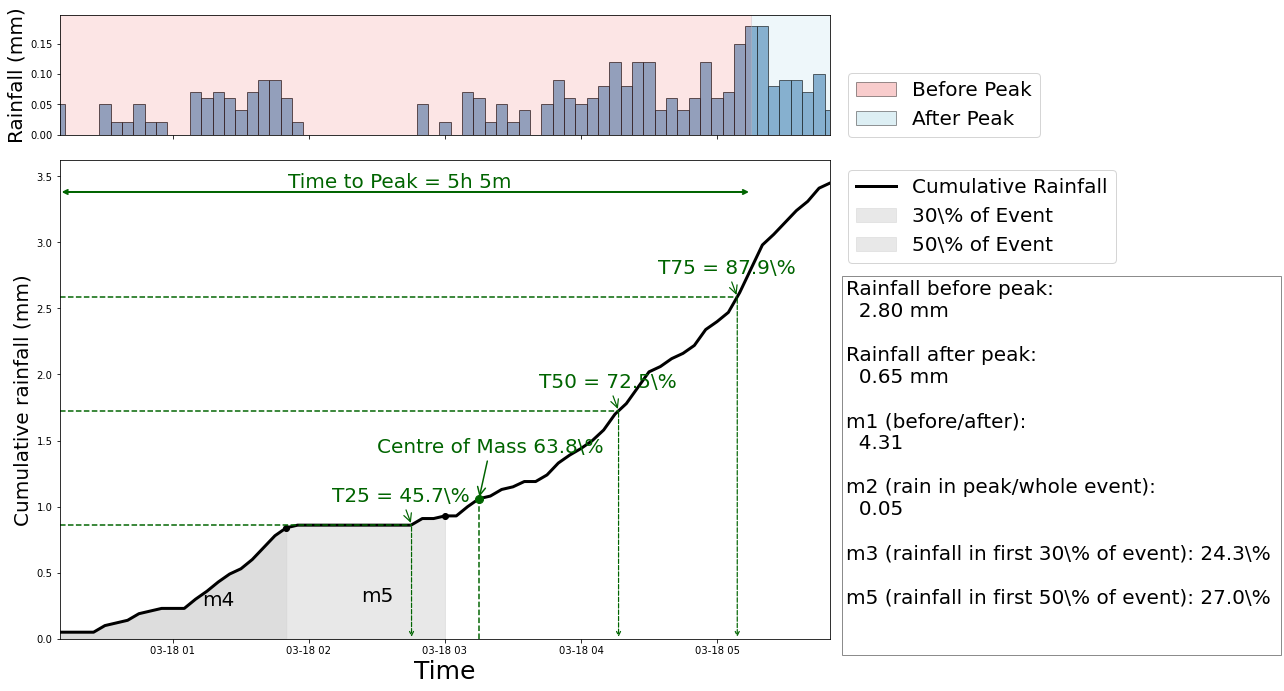

In [48]:
event_id = 2
gauge_id = 598120

file = open(f'/nfs/a319/gy17m2a/Metrics/DanishRainDataPickles/{gauge_id}_precip_minute.csv.pkl','rb')
object_file = pickle.load(file)

this_gauge_df = all_events_df[all_events_df['gauge_num']==gauge_id]
this_event_df = this_gauge_df[this_gauge_df['event_num']==event_id]
this_event_df.reset_index(inplace=True, drop=True)

event = object_file.raw_events[event_id]
plot_summary_stats(event, this_event_df, '', '../Figures/metrics_2.png')